# Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA



# Preproceessing

In [2]:
def preprocess_edge_dataset(file_path):
    # Loading the data
    Raw_Data = pd.read_csv(file_path, low_memory=False)
    # Fixing the fault in 'arp.hw.size' where 'frame.time' equals '6.0'
    idx_hw_6 = Raw_Data[Raw_Data['frame.time'] == '6.0'].index
    Raw_Data.loc[idx_hw_6, 'arp.hw.size'] = 6.0  # Fix the value to 6.0
    # Droping unnecessary columns by index
    Columns_to_drop = [0, 1, 2, 3, 6, 9, 10, 11, 13, 16, 19, 27, 31, 32, 34, 35, 50, 51, 54, 55, 59, 60]
    Raw_Data = Raw_Data.drop(Raw_Data.columns[Columns_to_drop], axis=1)
    # Removing target labels
    attack_label = Raw_Data.pop('Attack_label') if 'Attack_label' in Raw_Data else None
    attack_type = Raw_Data.pop('Attack_type') if 'Attack_type' in Raw_Data else None
    # Replacing categorical feature values as specified
    categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
    for feature in categorical_features:
        Raw_Data[feature] = Raw_Data[feature].replace('0', '0.0')
    # mapping Attack_type to 6 numerical values
    mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
    attack_type = attack_type.map(mapping_dict)
    # Removing Duplicates
    duplicate_index = Raw_Data.duplicated()
    Raw_Data = Raw_Data[~duplicate_index]
    Raw_Data, attack_label, attack_type = Raw_Data[~duplicate_index], attack_label[~duplicate_index], attack_type[~duplicate_index]

    return Raw_Data, attack_label, attack_type

file_path = "../Data/ML-EdgeIIoT-dataset.csv"
Data, Attack_label, Attack_type = preprocess_edge_dataset(file_path)

In [13]:
# Encoders and Scalers
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()
numerical_features = Data.select_dtypes(include=['float64']).columns.tolist()

numerical_transformer_rob = RobustScaler()
categorical_transformer_tar = TargetEncoder()

transformer_rob_tar = ColumnTransformer(
    transformers=[
        ('Robust Scaling numerical features', numerical_transformer_rob, numerical_features), # robust scaling
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])

X, Y = transformer_rob_tar.fit_transform(Data, Attack_label), Attack_label

# Feature Extraction : PCA

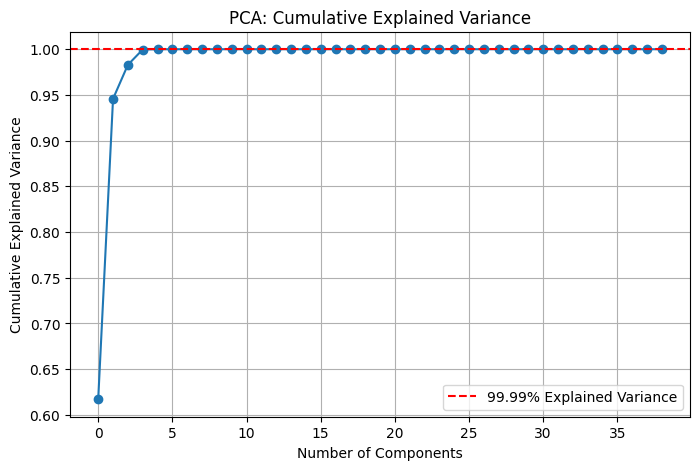

Optimal number of components: 5


In [16]:
pca = PCA().fit(X)

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.axhline(y=0.9999, color='r', linestyle='--', label='99.99% Explained Variance')
plt.legend()
plt.grid()
plt.show()

# Finding the optimal number of components
optimal_components = next(i for i, cumulative in enumerate(cumulative_variance) if cumulative >= 0.9999) + 1
print(f"Optimal number of components: {optimal_components}")


# Feature Selection : RF

In [21]:
X_val, _, Y_val, _ = train_test_split(X, Y, train_size= 0.4, stratify= Y, random_state=22)

RF = RandomForestClassifier(random_state=22)
RF.fit(X_val, Y_val)

# Extracting feature importance
feature_importance = RF.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Displaying sorted feature importance
selected_features = np.array([])
for i in sorted_idx:
    print(f"{i} >> Feature {Data.columns[i]}: Importance {feature_importance[i]}")
    if feature_importance[i] >= 0.0025:
        selected_features = np.append(selected_features, Data.columns[i]) 

6 >> Feature http.referer: Importance 0.25787222215733796
16 >> Feature tcp.flags: Importance 0.2166107796119456
8 >> Feature http.response: Importance 0.10448186472226946
7 >> Feature http.request.version: Importance 0.0750965648639252
13 >> Feature tcp.connection.rst: Importance 0.07203256441227145
27 >> Feature dns.retransmit_request: Importance 0.058078785953986
29 >> Feature mqtt.conack.flags: Importance 0.05629197650004271
15 >> Feature tcp.connection.synack: Importance 0.05266411659328488
28 >> Feature dns.retransmit_request_in: Importance 0.027338278514633337
14 >> Feature tcp.connection.syn: Importance 0.013219667197596695
10 >> Feature tcp.ack_raw: Importance 0.01219047417907922
11 >> Feature tcp.checksum: Importance 0.00571624696756851
25 >> Feature dns.qry.type: Importance 0.005395917561770206
9 >> Feature tcp.ack: Importance 0.0044929173827499775
38 >> Feature mbtcp.len: Importance 0.0044306213255155425
31 >> Feature mqtt.conflags: Importance 0.0043835841537731264
26 >> Fe

<Axes: >

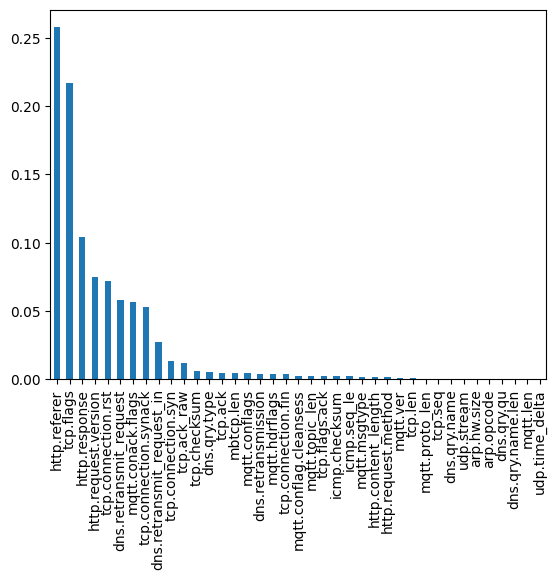

In [15]:
Feature_importance = pd.DataFrame(feature_importance.flatten(), index=Data.columns).sort_values(by=0, ascending=False)
Feature_importance.plot(kind='bar', legend=False)

In [22]:
selected_features

array(['http.referer', 'tcp.flags', 'http.response',
       'http.request.version', 'tcp.connection.rst',
       'dns.retransmit_request', 'mqtt.conack.flags',
       'tcp.connection.synack', 'dns.retransmit_request_in',
       'tcp.connection.syn', 'tcp.ack_raw', 'tcp.checksum',
       'dns.qry.type', 'tcp.ack', 'mbtcp.len', 'mqtt.conflags',
       'dns.retransmission', 'mqtt.hdrflags', 'tcp.connection.fin',
       'mqtt.conflag.cleansess', 'mqtt.topic_len'], dtype='<U32')